In [22]:
import pandas as pd
import seaborn as sns

# Carregando o dataset
raw_dataset = pd.read_csv('dataset_.csv')
# Exibindo as primeiras linhas do dataset
raw_dataset.head()


,idade,genero,imc,filhos,fumante,regiao,encargos
0,58,masculino,18.550237,2,não,nordeste,11243.095420
1,24,masculino,30.990835,0,sim,sudoeste,17424.179275
2,50,masculino,30.347391,5,NaN,nordeste,46555.413713
3,35,masculino,34.693762,1,NaN,centro-oeste,23663.428631
4,31,não informado,20.248626,3,sim,centro-oeste,53389.307081


In [23]:
# Verificando se o dataset possui valores nulos e exibindo informações gerais
print(raw_dataset.info())
print(raw_dataset.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idade     10000 non-null  int64  
 1   genero    7484 non-null   object 
 2   imc       10000 non-null  float64
 3   filhos    10000 non-null  int64  
 4   fumante   7435 non-null   object 
 5   regiao    10000 non-null  object 
 6   encargos  10000 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 547.0+ KB
None
idade          0
genero      2516
imc            0
filhos         0
fumante     2565
regiao         0
encargos       0
dtype: int64


In [24]:
# Substituindo os valores binários de 'genero' e 'fumante' por 0 e 1 e separando a coluna 'regiao' em novas colunas binárias
num_dataset = raw_dataset.copy()
num_dataset = pd.get_dummies(num_dataset,prefix='regiao', columns=['regiao'])
num_dataset['genero'] = num_dataset['genero'].map({'masculino': 0, 'feminino': 1})
num_dataset['fumante'] = num_dataset['fumante'].map({'não': 0, 'sim': 1})
num_dataset.head()

,idade,genero,imc,filhos,fumante,encargos,regiao_centro-oeste,regiao_nordeste,regiao_norte,regiao_sudoeste,regiao_sul
0,58,0.0,18.550237,2,0.0,11243.095420,False,True,False,False,False
1,24,0.0,30.990835,0,1.0,17424.179275,False,False,False,True,False
2,50,0.0,30.347391,5,NaN,46555.413713,False,True,False,False,False
3,35,0.0,34.693762,1,NaN,23663.428631,True,False,False,False,False
4,31,NaN,20.248626,3,1.0,53389.307081,True,False,False,False,False


In [25]:
# Substituindo os valores nulos por medianas para as colunas numéricas
num_dataset['genero'] = num_dataset['genero'].fillna(num_dataset['genero'].median())
num_dataset['fumante'] = num_dataset['fumante'].fillna(num_dataset['fumante'].median())

# Verificando novamente se o dataset possui valores nulos e exibindo informações gerais
print(num_dataset.info())
print(num_dataset.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   idade                10000 non-null  int64  
 1   genero               10000 non-null  float64
 2   imc                  10000 non-null  float64
 3   filhos               10000 non-null  int64  
 4   fumante              10000 non-null  float64
 5   encargos             10000 non-null  float64
 6   regiao_centro-oeste  10000 non-null  bool   
 7   regiao_nordeste      10000 non-null  bool   
 8   regiao_norte         10000 non-null  bool   
 9   regiao_sudoeste      10000 non-null  bool   
 10  regiao_sul           10000 non-null  bool   
dtypes: bool(5), float64(4), int64(2)
memory usage: 517.7 KB
None
idade                  0
genero                 0
imc                    0
filhos                 0
fumante                0
encargos               0
regiao_centro-oeste    0
r

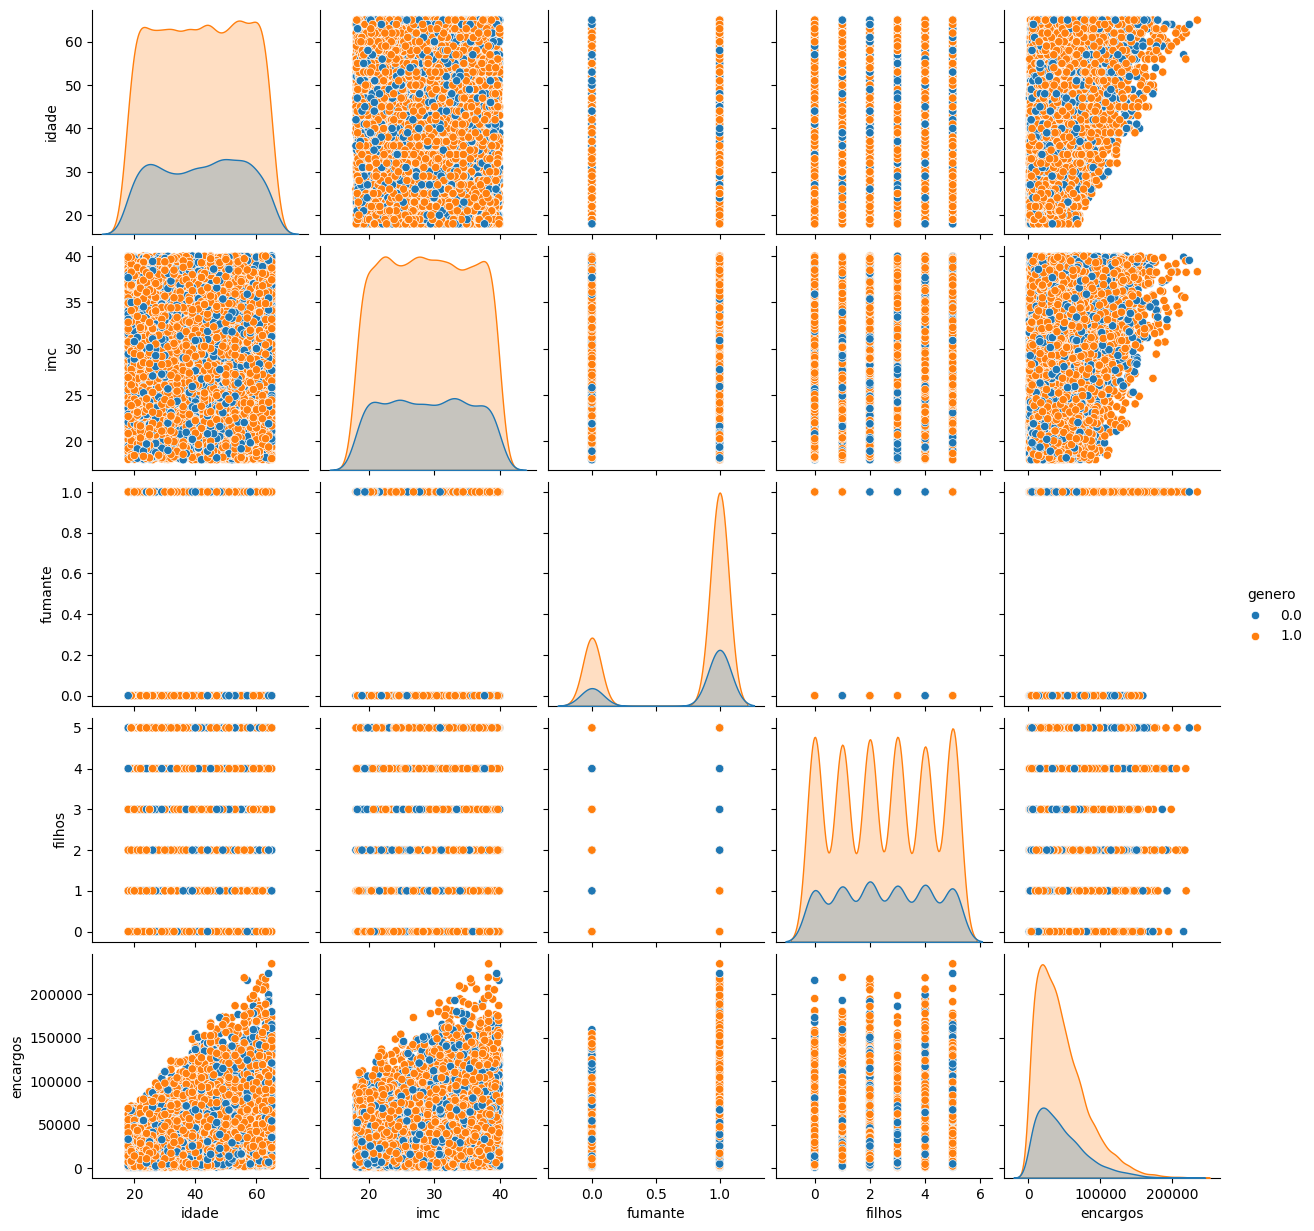

In [28]:
#Exibindo gráficos de dispersão geral do dataset separados por gênero
sns.pairplot(data=num_dataset, hue='genero', vars=['idade', 'imc', 'fumante', 'filhos','encargos'])